In [1]:
import praw
import time
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, pipeline

## Step 1 - Load our trained model & tokenizer

In [2]:
model = DistilBertForSequenceClassification.from_pretrained("./db_model")
tokenizer = DistilBertTokenizer.from_pretrained("./db_model")

## Step 2 - Create a pipeline for sentiment analysis using our trained model & tokenizer

In [3]:
sentiment_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cpu


I received this message because I chose to develop this script on my laptop rather than my PC which was used to train the model originally. As a result, it uses a CPU rather than a GPU.

## Step 3 - Apply custom mapping to test on multiple sentences at once
Just to test things out, I collected some relatively negative Reddit comments to evaluate the model. I did this to see how it performed on real-world language and to properly map out LABEL_0, 1, and 2 to Negative, Neutral, and Positive values to make them easily understood.

In [4]:
sentences = [
    "These CFB fans have been outright dirtbags this year. The worst segment of the population",
    "Of course my guy is the one who gets hurt. Just my luck.",
    "Indiana not a top-5 team. They're gonna get rolled in their first playoff game. No Oregon, no PSU, and they got whupped by OSU. They're an illusion."
]

results = sentiment_analyzer(sentences)

# Mapping our labels
label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
custom_results = [
    {"sentence": sentence, "sentiment": label_map[result['label']], "score": result['score']}
    for sentence, result in zip(sentences, results)
]

# Printing the results
for res in custom_results:
    print(f"Sentence: {res['sentence']}")
    print(f"Predicted Sentiment: {res['sentiment']} with confidence of {res['score']:.2f}")

Sentence: These CFB fans have been outright dirtbags this year. The worst segment of the population
Predicted Sentiment: Negative with confidence of 1.00
Sentence: Of course my guy is the one who gets hurt. Just my luck.
Predicted Sentiment: Negative with confidence of 0.98
Sentence: Indiana not a top-5 team. They're gonna get rolled in their first playoff game. No Oregon, no PSU, and they got whupped by OSU. They're an illusion.
Predicted Sentiment: Negative with confidence of 1.00


As we can see, our model predicts negative sentiment for these comments as we would expect, so it is performing well.

## Step 4 - Import Reddit Credentials

In [5]:
import reddit_credentials as rc

reddit = praw.Reddit(client_id=rc.client_id, 
                     client_secret=rc.client_secret, 
                     user_agent=rc.user_agent, 
                     username=rc.username, 
                     password=rc.password)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


## Step 5 - Implement a Keyword Search

In [6]:
def generate_keywords(player_name):
    """
    Dynamically generate keywords for searching Reddit comments based on player name.
    """
    name_parts = player_name.split()  # Split into parts (e.g., "Jalen Hurts" -> ["Jalen", "Hurts"])
    keywords = [player_name]  # Include full name
    keywords.extend(name_parts)  # Add individual parts (e.g., "Jalen" and "Hurts")
    return keywords

def get_comments_with_keywords(reddit, subreddit_name, keywords, total_comments=1000):
    """
    Fetch comments from a subreddit that specifically mention the given keywords.
    """
    subreddit = reddit.subreddit(subreddit_name)
    
    filtered_comments = []
    count = 0

    for comment in subreddit.comments(limit=total_comments):
        try:
            # Check if the comment contains any of the keywords (case-insensitive)
            if any(keyword.lower() in comment.body.lower() for keyword in keywords):
                filtered_comments.append({
                    'Comment': comment.body,
                    'Created_UTC': comment.created_utc,  # Unix timestamp
                    'Comment_ID': comment.id
                })
                count += 1

                # Stop fetching if we've reached the desired number of filtered comments
                if count >= total_comments:
                    break
        except Exception as e:
            print(f"Error processing comment: {e}")
            continue

    return filtered_comments

## Step 6 - Function to get comments with keyword search from multiple subreddits at once

In [7]:
def get_comments_from_subreddits(reddit, subreddits, keywords, total_comments_per_subreddit=1000, verbose=False):
    """
    Fetch comments from multiple subreddits containing specific keywords.
    """
    all_comments = []
    total_found = 0

    for subreddit_name in subreddits:
        if verbose:
            print(f"Processing subreddit: r/{subreddit_name}")
        subreddit_comments = get_comments_with_keywords(reddit, subreddit_name, keywords, total_comments_per_subreddit)
        total_found += len(subreddit_comments)
        all_comments.extend(subreddit_comments)

    print(f"Total comments about this player: {total_found}")
    return all_comments

## Step 7 - Define a Sentiment Analysis Function

In [8]:
def analyze_sentiment(comments, keywords):
    """
    Analyze sentiment for a list of comments, calculate counts for each sentiment,
    and calculate the average timestamp.
    """
    # Get sentiment predictions
    sentiment_results = sentiment_analyzer([comment['Comment'] for comment in comments])
    
    # Map labels to human-readable categories
    label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
    
    # Prepare sentiment analysis results
    results = []
    timestamps = []
    for comment, result in zip(comments, sentiment_results):
        sentiment = label_map[result['label']]
        results.append({
            'Comment': comment['Comment'],
            'Sentiment': sentiment,
            'Score': result['score']
        })
        timestamps.append(comment['Created_UTC'])  # Collect timestamps
    
    # Count each sentiment
    sentiment_counts = Counter([res['Sentiment'] for res in results])
    most_common_sentiment = sentiment_counts.most_common(1)[0]  # Get the most frequent sentiment

    # Calculate the average timestamp
    avg_timestamp = sum(timestamps) / len(timestamps) if timestamps else 0
    avg_datetime = datetime.utcfromtimestamp(avg_timestamp).strftime('%Y-%m-%d %H:%M:%S') if avg_timestamp else "N/A"
    
    # Display results
    print("\nSentiment Counts:")
    for sentiment, count in sentiment_counts.items():
        print(f"{sentiment}: {count}")
    print(f"\nMost Common Sentiment: {most_common_sentiment[0]} ({most_common_sentiment[1]} comments)")
    print(f"Average Timestamp: {avg_datetime}")
    
    # Return both sentiment counts and analysis results
    return sentiment_counts, results

In [9]:
def plot_sentiment_counts(sentiment_counts, player_name):
    """
    Plot a bar chart for sentiment counts.
    """
    # Data for the chart
    sentiment_labels = list(sentiment_counts.keys())
    sentiment_values = list(sentiment_counts.values())

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(sentiment_labels, sentiment_values, color=['blue', 'green', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Comments')
    plt.title(f'Sentiment Analysis for {player_name}')
    plt.show()

## Step 8 - Perform a Sentiment Search
As an example, I performed a sentiment search on Caleb Williams, who recorded around his average of 17 fantasy points on Sunday's game.

Total comments about this player: 108

Sentiment Counts:
Positive: 50
Neutral: 18
Negative: 40

Most Common Sentiment: Positive (50 comments)
Average Timestamp: 2024-12-08 20:54:08


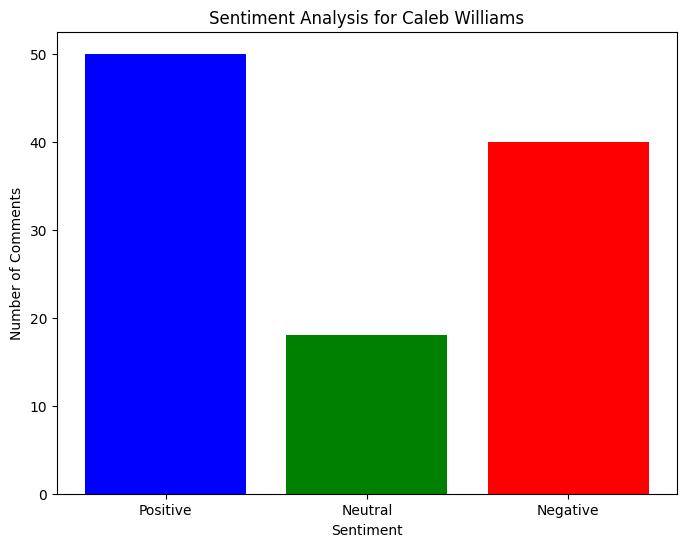

In [10]:
player_name = "Caleb Williams"
keywords = generate_keywords(player_name)

subreddits = ["nfl", "fantasyfootball", "nflmemes", "espn", "CHIBears"]  # List of subreddits to search
total_comments_per_subreddit = 1000

# Fetch comments across multiple subreddits
comments = get_comments_from_subreddits(reddit, subreddits, keywords, total_comments_per_subreddit, verbose=False)

# Analyze sentiment for found comments
if comments:
    sentiment_counts, analysis = analyze_sentiment(comments, keywords)  # Apply our model
    plot_sentiment_counts(sentiment_counts, player_name)  # Plot the sentiment counts
else:
    # Default to a Neutral sentiment if no comments are found
    print(f"No comments mentioning {keywords} found in the given subreddits.")
    print("Sentiment: Neutral")

The result was a majority positive sentiment from Reddit users, albeit not by a huge margin. This may be likely due to the Bears losing that game in particular, despite Williams' performance, as fans likely used his name in conjunction with complaints almost as much as praises.

## Search #2 - Justin Jefferson
For our second search, I decided to look at Reddit's opinion on Justin Jefferson, who performed well above his average by recording 25 points on Sunday's game that the Vikings won, which was far above his average of 11.7.

To make this analysis more effective, I also replaced the Bears subreddit with the Vikings' one to see if it more comments from fans who may be talking about this player in particular.

Total comments about this player: 22

Sentiment Counts:
Positive: 14
Negative: 6
Neutral: 2

Most Common Sentiment: Positive (14 comments)
Average Timestamp: 2024-12-08 21:41:01


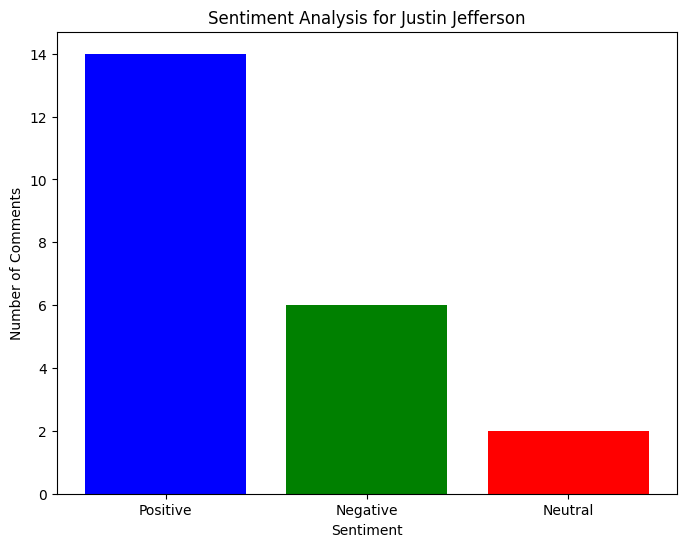

In [11]:
player_name = "Justin Jefferson"
keywords = generate_keywords(player_name)

subreddits = ["nfl", "fantasyfootball", "nflmemes", "espn", "minnesotavikings"]  # List of subreddits to search
total_comments_per_subreddit = 1000

# Fetch comments across multiple subreddits
comments = get_comments_from_subreddits(reddit, subreddits, keywords, total_comments_per_subreddit, verbose=False)

# Analyze sentiment for found comments
if comments:
    sentiment_counts, analysis = analyze_sentiment(comments, keywords)  # Apply our model
    plot_sentiment_counts(sentiment_counts, player_name)  # Plot the sentiment counts
else:
    # Default to a Neutral sentiment if no comments are found
    print(f"No comments mentioning {keywords} found in the given subreddits.")
    print("Sentiment: Neutral")

As one would expect, Justin Jefferson obtained an overwhelmingly positive score as this was his best performing game of the season so far.

## Search #3 - Dustin Hopkins
Lastly, I wanted to look at some results for a player whose team lost and they individually underperformed in order to see if there was any dramatic backlash. Dustin Hopkins is a kicker for the Cleveland Browns who averages 5.2 fantasy points per week, but only recorded 2 points in this Sunday's loss. Additionally, both throughout and after the game, there was great backlash regarding the Browns' kicking performance, so I wanted to see if Redditors covered this.

Once again, I swapped out the team specific subreddit for the Browns' subreddit, r/Browns

Total comments about this player: 42

Sentiment Counts:
Positive: 11
Negative: 16
Neutral: 15

Most Common Sentiment: Negative (16 comments)
Average Timestamp: 2024-12-08 22:11:07


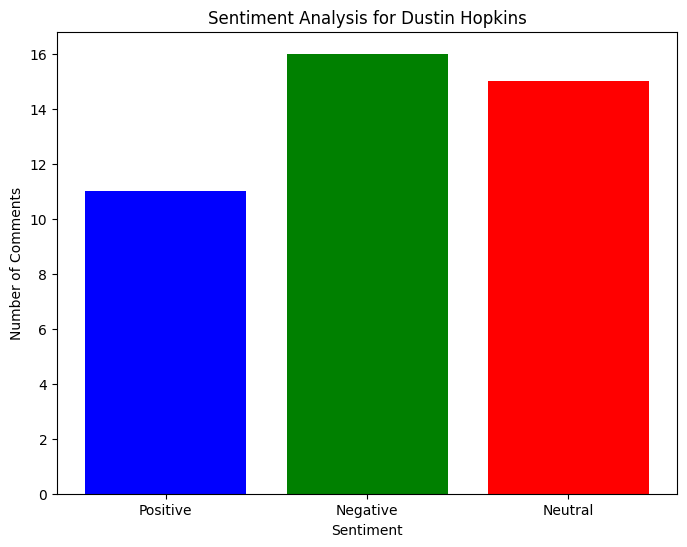

In [14]:
player_name = "Dustin Hopkins"
keywords = generate_keywords(player_name)

subreddits = ["nfl", "fantasyfootball", "nflmemes", "espn", "Browns"]  # List of subreddits to search
total_comments_per_subreddit = 1000

# Fetch comments across multiple subreddits
comments = get_comments_from_subreddits(reddit, subreddits, keywords, total_comments_per_subreddit, verbose=False)

# Analyze sentiment for found comments
if comments:
    sentiment_counts, analysis = analyze_sentiment(comments, keywords)  # Apply our model
    plot_sentiment_counts(sentiment_counts, player_name)  # Plot the sentiment counts
else:
    # Default to a Neutral sentiment if no comments are found
    print(f"No comments mentioning {keywords} found in the given subreddits.")
    print("Sentiment: Neutral")

As we can see, most comments towards Hopkins on Sunday were negative, but luckily there were a high amount of neutral comments towards him and a few positive as well.

This is encouraging, as while he had a bad performance in missing two field goals, it is encouraging to see that some fans still show strong Postive and even Neutral support.